# Application of Deep Knockoffs for Functional Magnetic Resonance Imaging to Generate Surrogate Data

This notebook describes the pipeline to follow to build Knockoffs from fMRI images. These knockoffs generate surrogate data that is used in non-parametric tests to obtain a Statistical Parametric Map (SPM) of the brain.

First of all, some things to consider:
* fMRI images have been obtained from the Brain Connectome Project and previously preprocessed. 
* The Knockoff library can be found at https://github.com/msesia/deepknockoffs.git


## Structure
The process is divided into 3 main parts, which consist of:
#### 1. Performing the **General Linear Model (GLM)** on the data
This is the classical method to obtain the SPM, which returns the fitted beta values for $$ y = X\beta$$ where y is the fMRI timecourse and X is the design matrix of the experiment.


#### 2. Generating Knockoffs
Given the data, the algorithm will build a machine to generate surrogate timecourses. 
There are three methods:
* Gaussian Knockoffs
* Low Rank Knockoffs
* Deep Knockoffs
    
    
#### 3. Performing **Non-Parametric Tests**
The GLM is applied to the generated surrogate data to get the beta values and these are used to threshold the true betas using Non-Parametric Tests, which can be:
* Uncorrected Non-Parametric Test
* Corrected Non-Parametric Test
    
#### 4. Visualizing the results
* Brain plot (Matlab)
* Confusion matrix




In [20]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

from implementation import glm, knockoff_class, params
from implementation.load import load_pickle
from implementation.utils import KNOCK_DIR

## 1. GLM

In [6]:
glm.run()

 MOTOR 
Loading data for task MOTOR...
Loaded Data - Shape: (100, 379, 284)
Loaded Task Paradigms - Shape: (100, 284)
Computing GLM for task MOTOR...
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 100 subjects and 379 regions...
Done!
Saving activations and beta values for task MOTOR...
 GAMBLING 
Loading data for task GAMBLING...
Loaded Data - Shape: (100, 379, 253)
Loaded Task Paradigms - Shape: (100, 253)
Computing GLM for task GAMBLING...
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 100 subjects and 379 regions...
Done!
Saving activations and beta values for task GAMBLING...
 RELATIONAL 
Loading data for task RELATIONAL...
Loaded Data - Shape: (100, 379, 232)
Loaded Task Paradigms - Shape: (100, 232)
Computing GLM for task RELATIONAL...
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 100 subjects and 379 regions...
Done!
Saving activations and beta values for task RELATIONAL...
 SOCIAL 
Loading data for task SOCIAL...
Loa

## 2. Building Knockoffs

In [22]:
task = 'MOTOR'
subject = 1

# Loading all the data
fmri_data = load_fmri(task=task)

Loaded Data - Shape: (100, 379, 284)


### a) Gaussian Knockoffs

Loaded Data - Shape: (100, 379, 284)
Divided 379 variables into 154 groups.
Divided 379 variables into 154 groups.
Size of largest groups: 37
Mean groups size: 2.461038961038961
Eigenvalue for Sigma Hat, Min: -4.006705455559442e-15
Eigenvalue for Sigma Hat Representatives, Min: 0.04360734588940268
Original for Correlations, Max: 0.8022580778679829
Representatives for Correlations, Max: 0.4585931438028127
Average absolute pairwise correlation: 0.859.


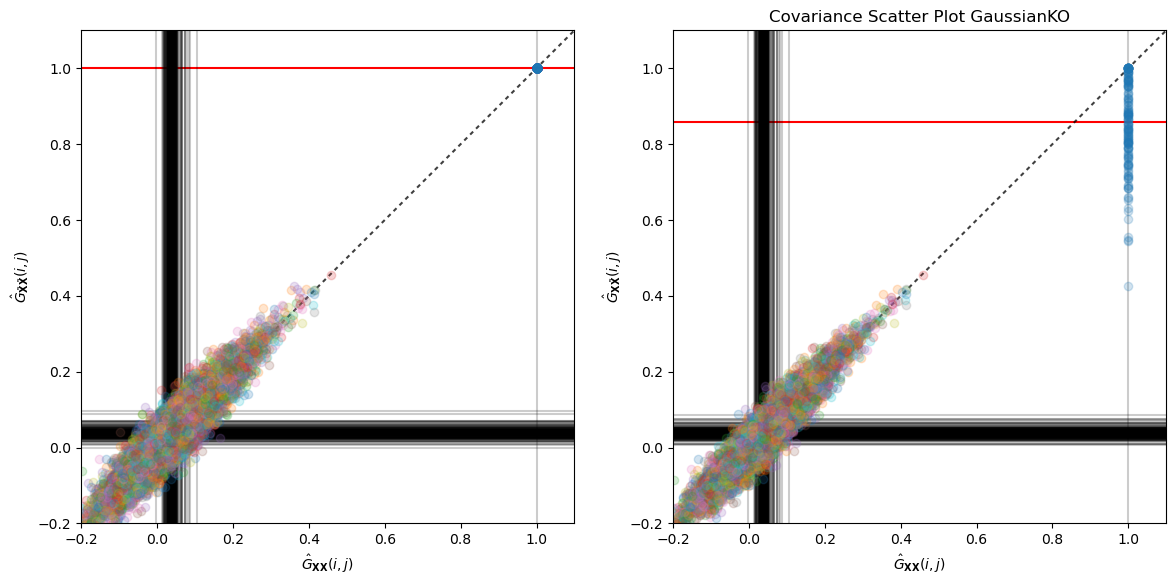

                               Value                                     \
                               count        mean        std         min   
Method     Metric     Swap                                                
GaussianKO Covariance full     100.0  235.452639  14.144743  199.986523   
                      partial  100.0  261.081200  14.141453  217.029431   
                      self     100.0    0.858805   0.001080    0.856716   
           Energy     full     100.0    0.308617   0.005518    0.296722   
                      partial  100.0    0.309588   0.005575    0.298075   
           KNN        full     100.0    0.647993   0.020686    0.580986   
                      partial  100.0    0.657958   0.021947    0.591549   
           MMD        full     100.0   -0.001865   0.000326   -0.002545   
                      partial  100.0   -0.001761   0.000323   -0.002386   

                                                                               
                   

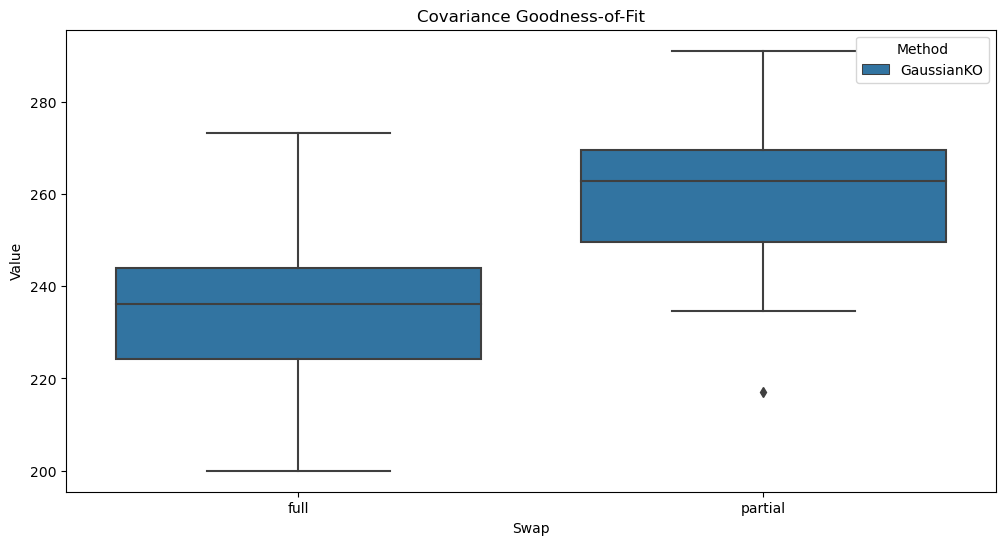

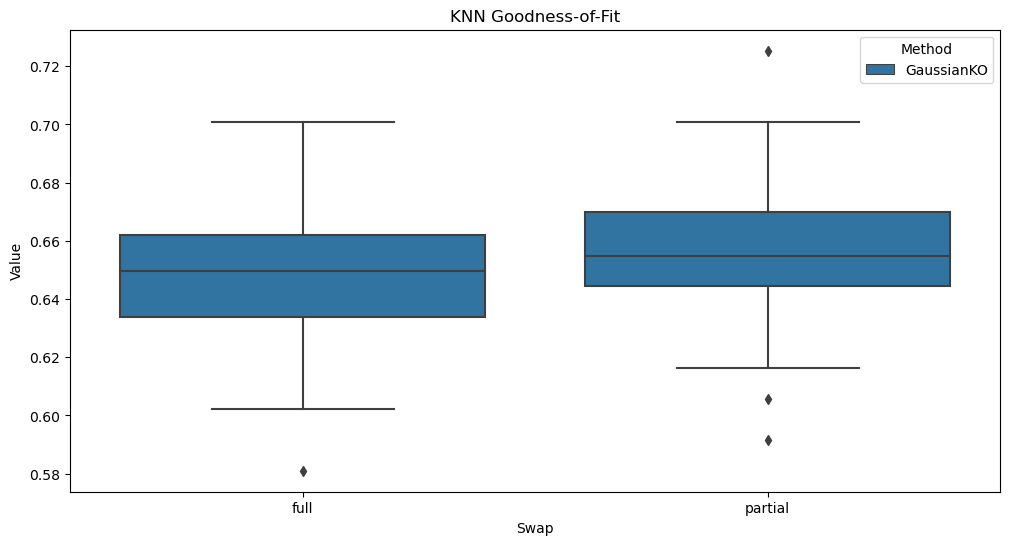

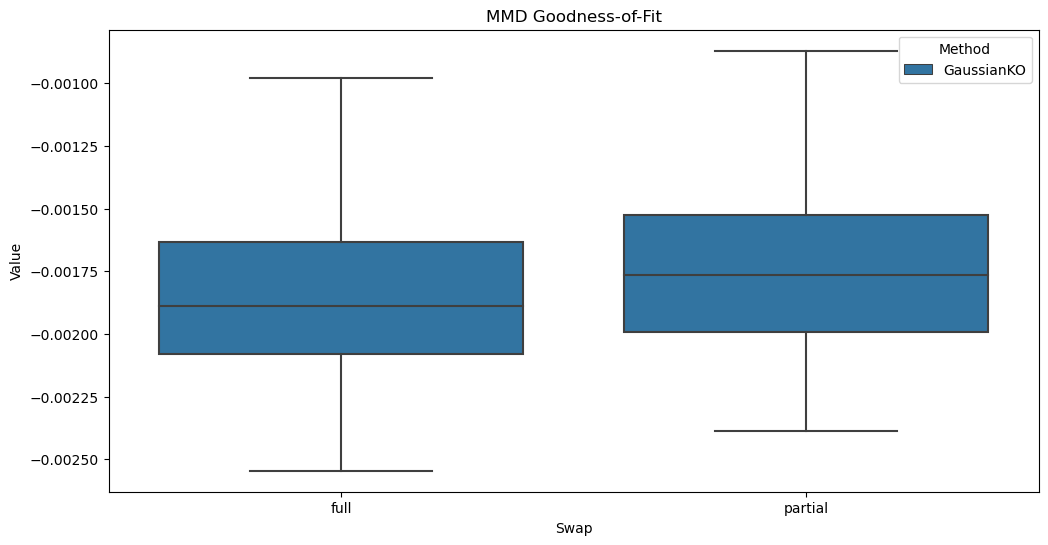

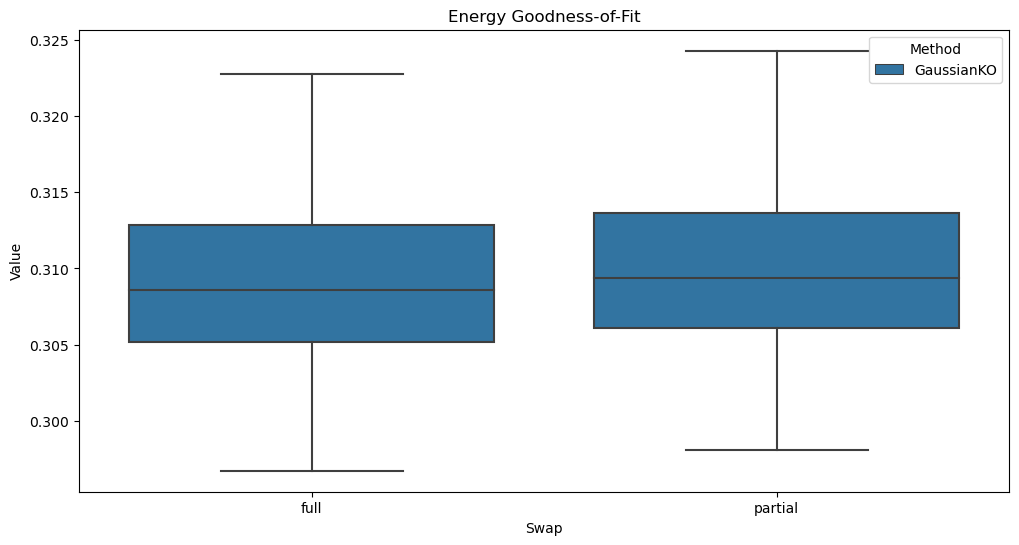

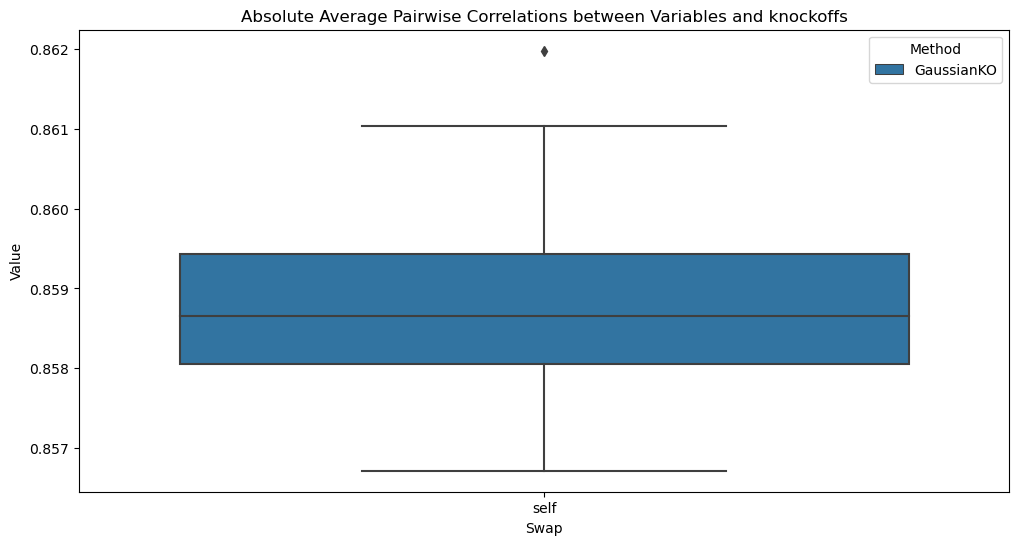

In [31]:
gaussian = knockoff_class.GaussianKnockOff(task, subject)  

gaussian.load_fmri()

# Pre-processing the data: clustering to avoid correlations
gaussian.pre_process(max_corr=.3)

# Training the machine to build second-order knockoffs
_ = gaussian.fit() 

# Plotting diagnostics to show the performance of the knockoffs
res_gaus = gaussian.diagnostics()

In [32]:
# Building the knockoffs: the resulting data matrix will be of shape (real+knockoff, timepoints, regions),
# with (0,:,:) containing the real beta value and (1:, :, :) containing the knockoffs
data_gaussian = gaussian.transform()
print(data_gaussian.shape)

(101, 284, 379)


### b) Low Rank Knockoffs

Loaded Data - Shape: (100, 379, 284)


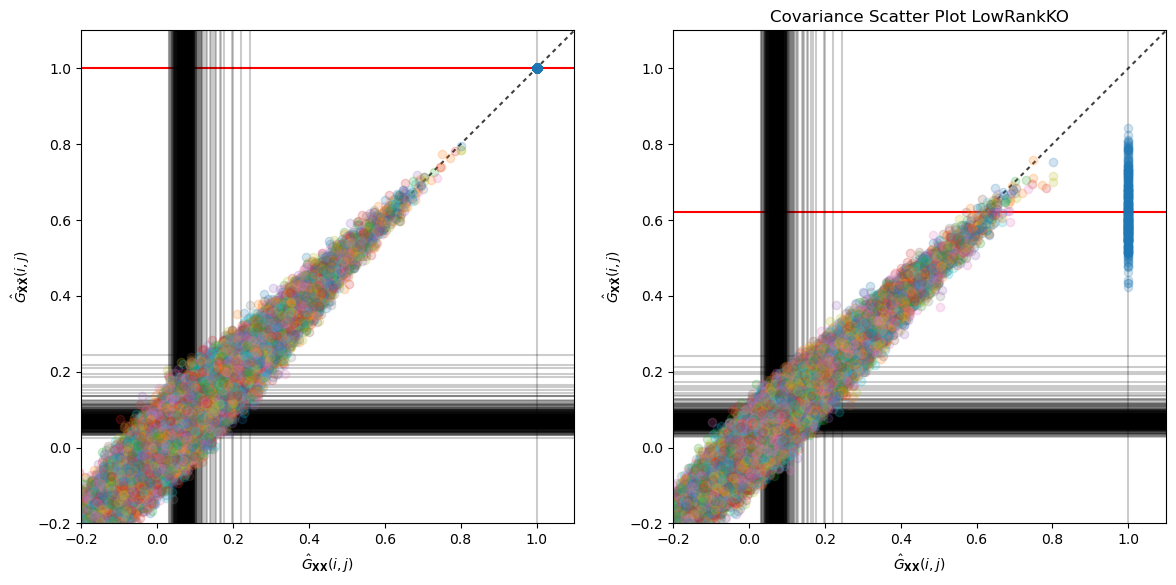

                              Value                                        \
                              count         mean         std          min   
Method    Metric     Swap                                                   
LowRankKO Covariance full     100.0  4008.062845  186.357036  3644.048198   
                     partial  100.0  4559.303639  182.913353  4187.957478   
                     self     100.0     0.620693    0.001492     0.617181   
          Energy     full     100.0     0.577933    0.012839     0.547366   
                     partial  100.0     0.583895    0.012873     0.556222   
          KNN        full     100.0     0.844683    0.016216     0.799296   
                     partial  100.0     0.870810    0.016091     0.823944   
          MMD        full     100.0     0.002638    0.000482     0.001535   
                     partial  100.0     0.003046    0.000487     0.002017   

                                                                     \
    

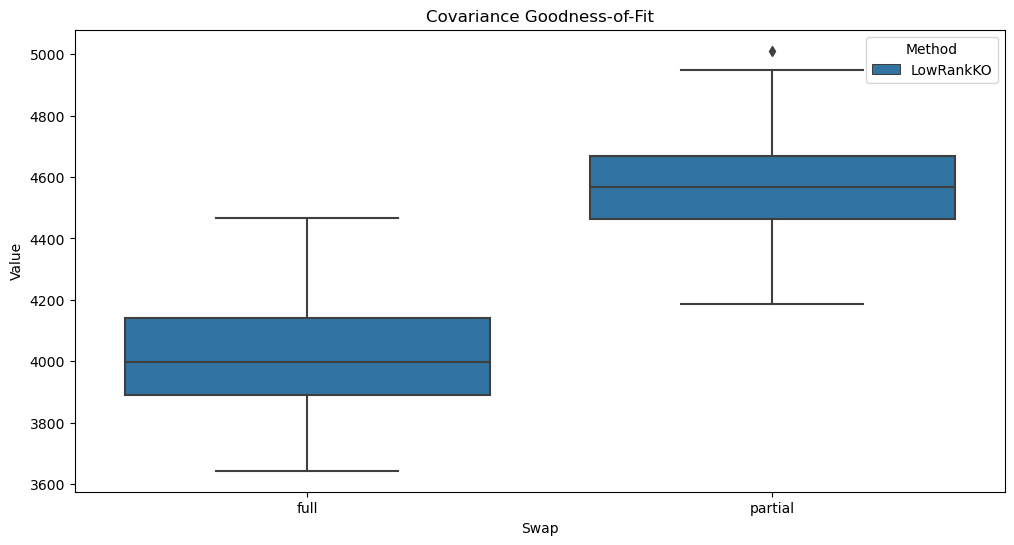

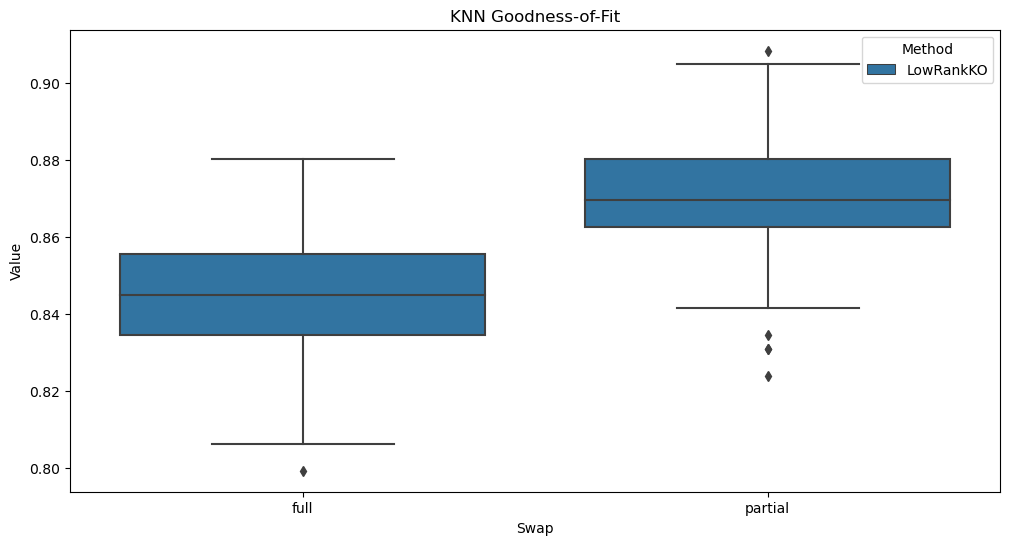

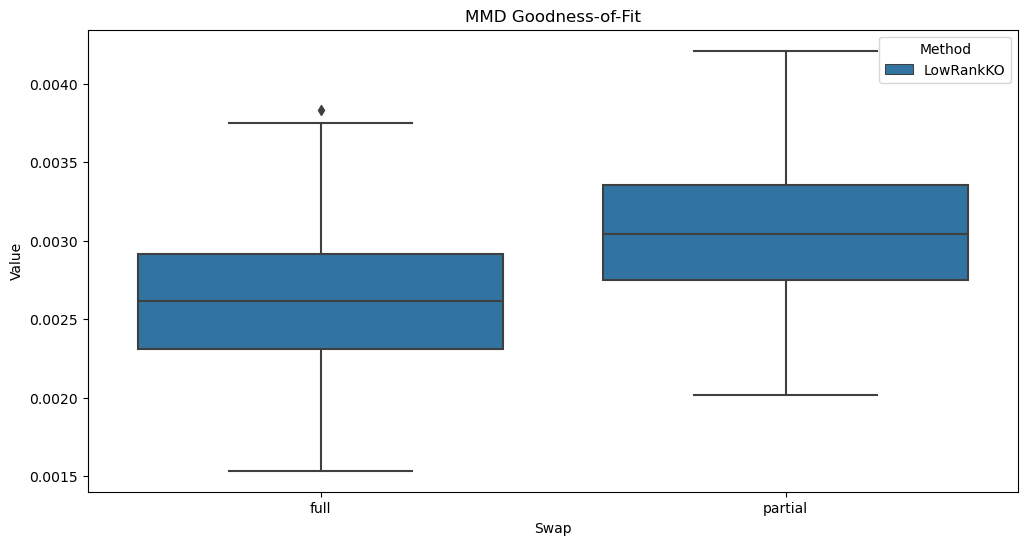

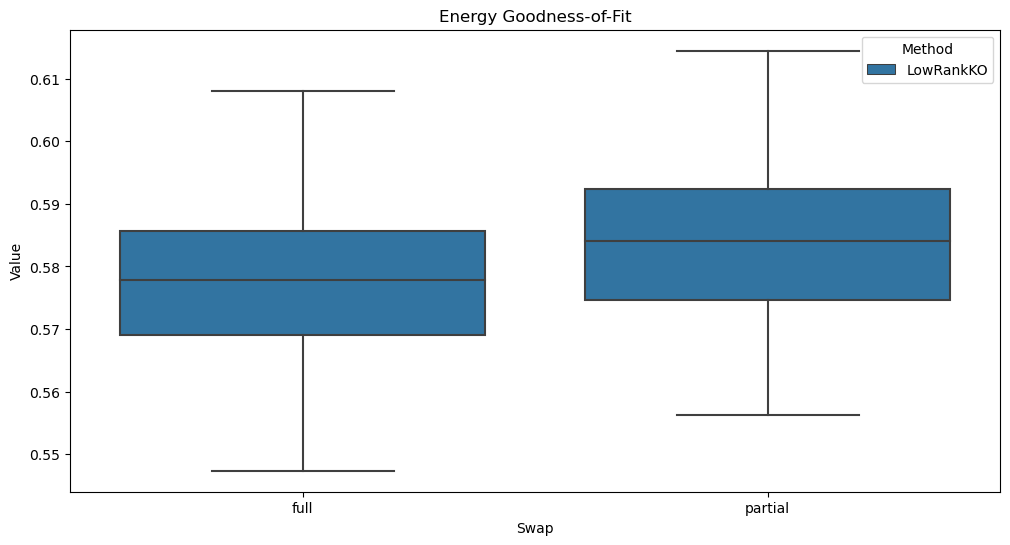

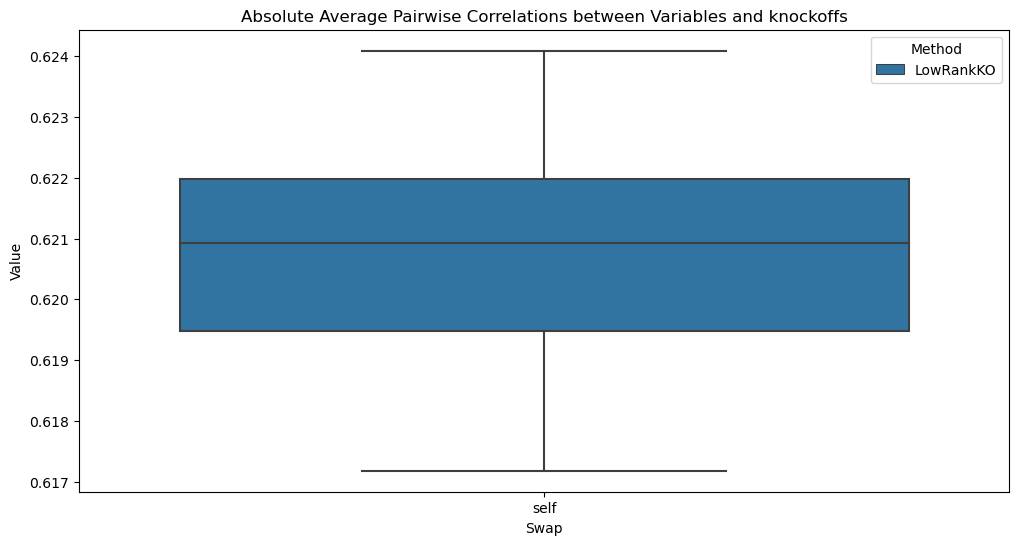

In [33]:
lowrank = knockoff_class.LowRankKnockOff(task, subject)  

lowrank.load_fmri()

# Training the machine to build low-ranked knockoffs
_ = lowrank.fit(rank=120) 

# Plotting diagnostics to show the performance of the knockoffs
res_lowrank = lowrank.diagnostics()

In [34]:
# Building the knockoffs: the resulting data matrix will be of shape (real+knockoff, timepoints, regions),
# with (0,:,:) containing the real beta value and (1:, :, :) containing the knockoffs
data_lowrank = lowrank.transform()
print(data_lowrank.shape)

(101, 284, 379)


### c) Deep Knockoffs

We can load a previously trained machine or train a new one.

* **Loading a machine**

Loaded Data - Shape: (100, 379, 284)
Divided 379 variables into 154 groups.
Divided 379 variables into 154 groups.
Size of largest groups: 37
Mean groups size: 2.461038961038961
Eigenvalue for Sigma Hat, Min: -4.006705455559442e-15
Eigenvalue for Sigma Hat Representatives, Min: 0.04360734588940268
Original for Correlations, Max: 0.8022580778679829
Representatives for Correlations, Max: 0.4585931438028127
Saving file GaussianKO_tfMRI_tMOTOR_s1_c0.3.pickle
Saving file GaussianKO_mapping_tMOTOR_s1_c0.3.pickle
Average absolute pairwise correlation: 0.859.
Saving file DeepKO_tMOTOR_s1_params
=> loading checkpoint '/Users/janet/EnginyeriaBiomèdica/MSc LIFE SCIENCES ENGINEERING/Machine learning/Project2/machine-learning-cs433-p2/data/output/knockoffs/DeepKO_tMOTOR_s1_checkpoint.pth.tar'
=> loaded checkpoint '/Users/janet/EnginyeriaBiomèdica/MSc LIFE SCIENCES ENGINEERING/Machine learning/Project2/machine-learning-cs433-p2/data/output/knockoffs/DeepKO_tMOTOR_s1_checkpoint.pth.tar' (epoch 5)


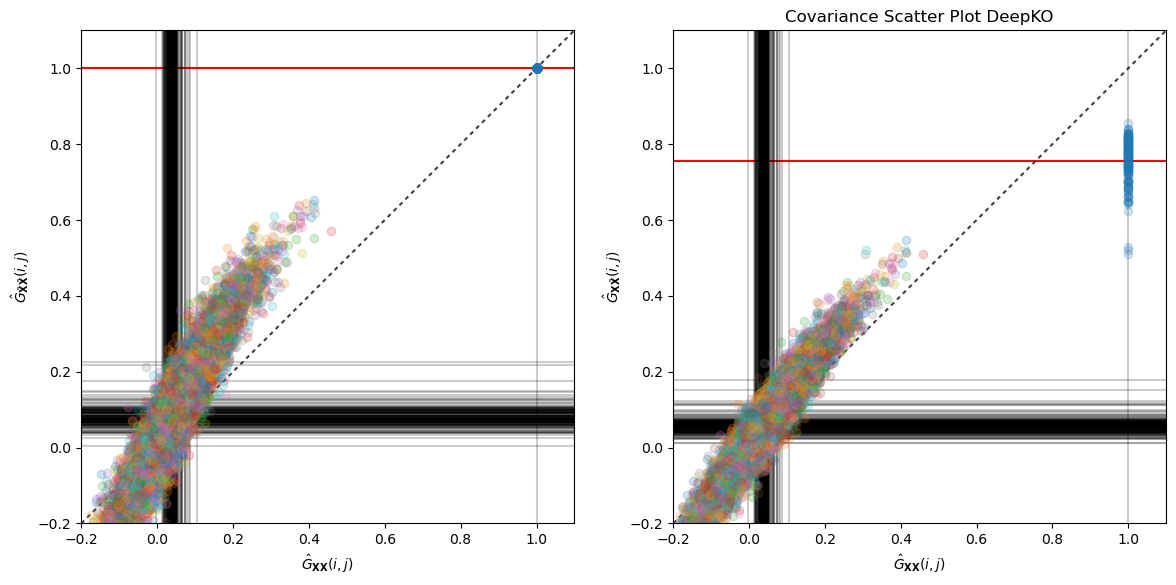

                           Value                                    \
                           count        mean       std         min   
Method Metric     Swap                                               
DeepKO Covariance full     100.0  201.439254  8.845920  178.123143   
                  partial  100.0  200.991749  8.057756  179.997998   
                  self     100.0    0.752290  0.001239    0.749281   
       Energy     full     100.0    0.277174  0.005480    0.264226   
                  partial  100.0    0.278733  0.005315    0.267071   
       KNN        full     100.0    0.711162  0.019438    0.672535   
                  partial  100.0    0.699965  0.019346    0.630282   
       MMD        full     100.0   -0.000358  0.000377   -0.001294   
                  partial  100.0   -0.000268  0.000369   -0.001089   

                                                                           
                                  25%         50%         75%         max  
Method 

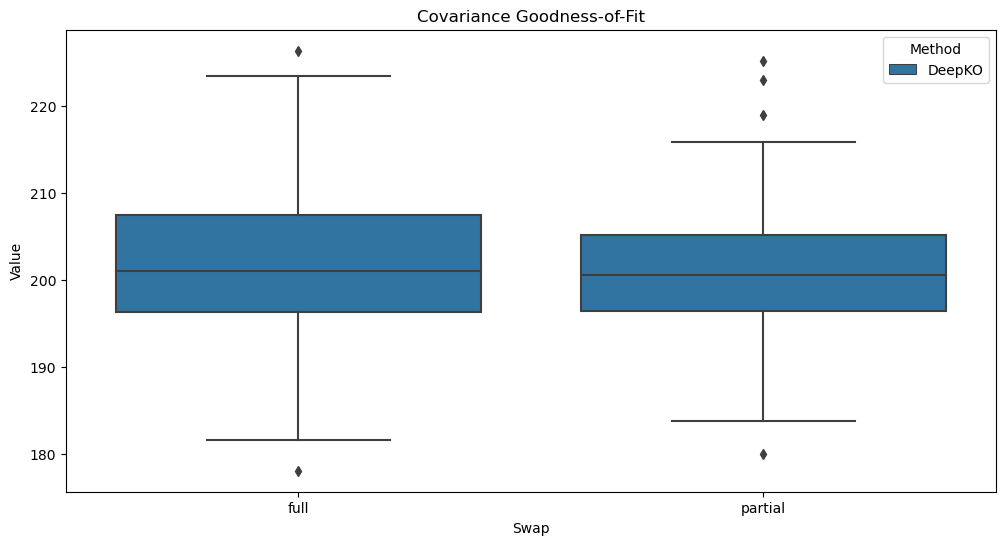

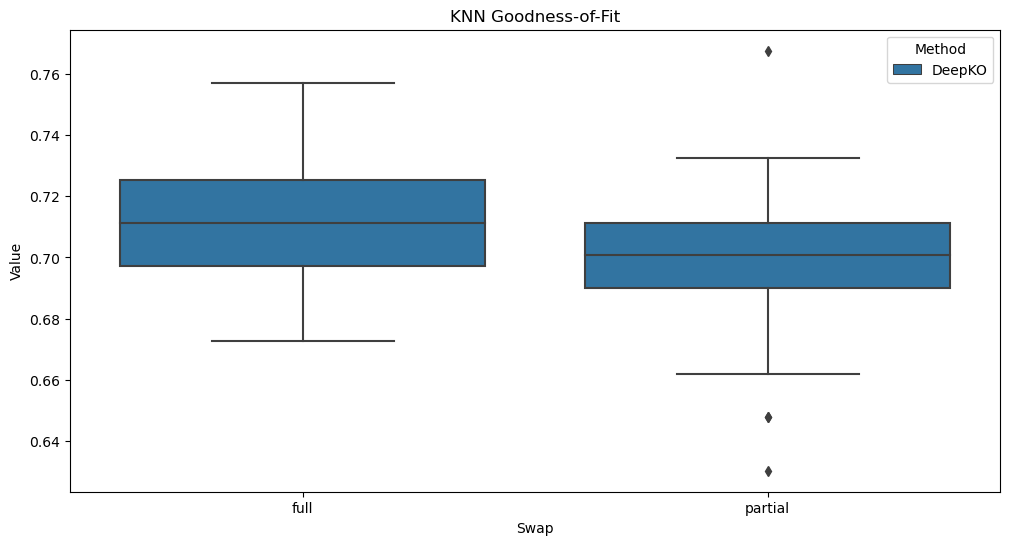

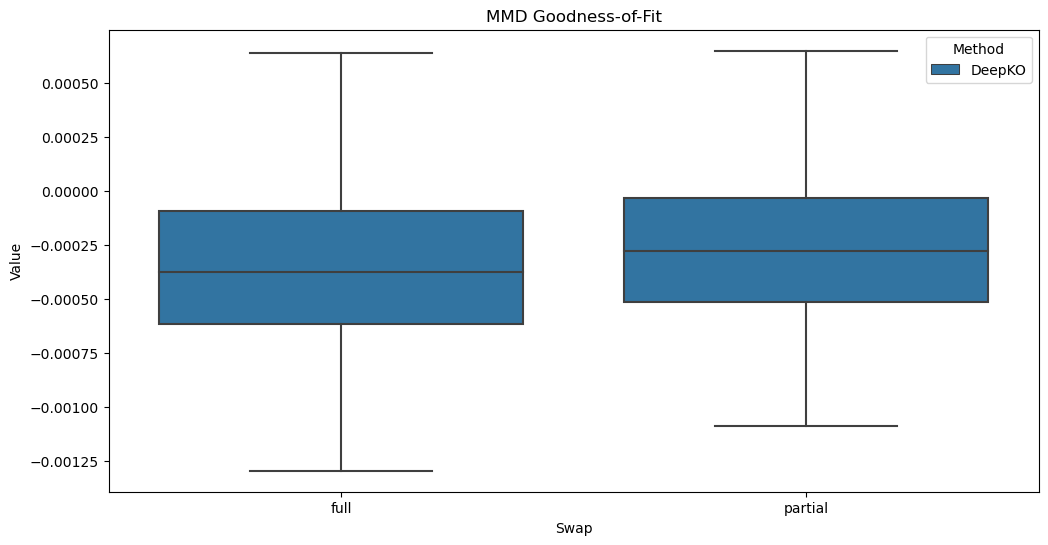

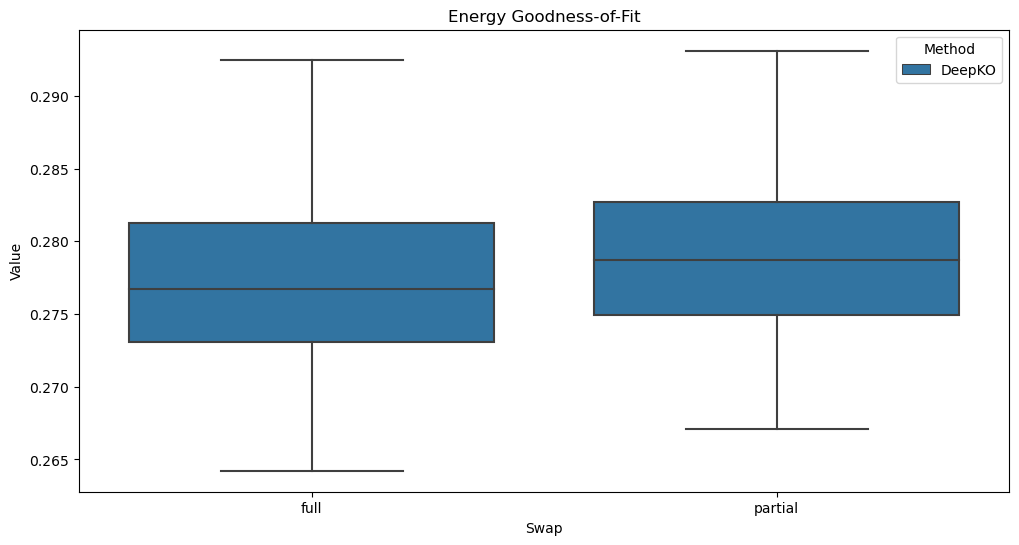

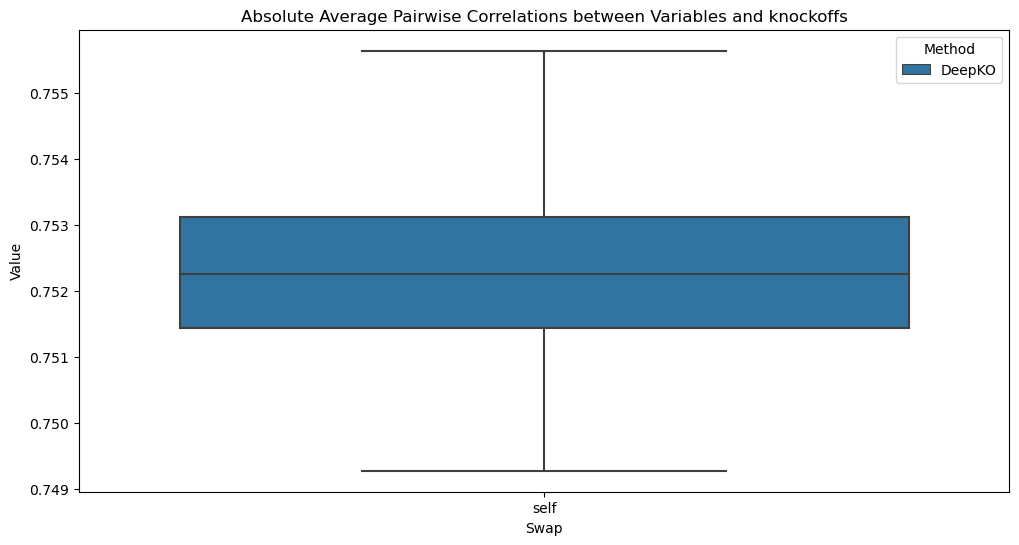

In [23]:
### We can load a previously trained machine

deepko = knockoff_class.DeepKnockOff(task, subject)
deepko.pre_process(max_corr=.3, save=True)

# Loading previously trained machine
_, x_train = load_pickle(KNOCK_DIR, f'GaussianKO_tfMRI_t{task}_s{subject}_c0.3.pickle')
groups, _ = load_pickle(KNOCK_DIR, f'GaussianKO_mapping_t{task}_s{subject}_c0.3.pickle')
#params = load_pickle(KNOCK_DIR, 'DeepKO_params_DeepKO_tMOTOR_s10')

deepko.load_x(x_train)
#deepko.load_params(params)
deepko.load_machine()

res_deepko = deepko.diagnostics()

In [25]:
data_deepko = deepko.transform(groups=groups)

deepko_betas = deepko.statistic(data_deepko, save=True)
uncorrected_betas_deepko, corrected_betas_deepko = deepko.threshold(deepko_betas, save=True)

Loaded Task Paradigms - Shape: (100, 284)
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 101 subjects and 379 regions...
Done!
Saving file DeepKO_KObetas_tMOTOR_s1.mat
Performing uncorrected non-parametric test...
Performing corrected non-parametric test...
Saving file DeepKO_uncorrected_betas_tMOTOR_s1.mat
Saving file DeepKO_corrected_betas_tMOTOR_s1.mat


* **Training a new machine**

In [ ]:
# Or train a new knockoff machine

deepko = knockoff_class.DeepKnockOff(task, subject)  

# Pre-processing the data: clustering to avoid correlations
deepko.pre_process(max_corr=.3, save=True)

# Training the machine to build second-order knockoffs. The parameters can be changed at params.py
_ = deepko.fit() 

# Plotting diagnostics to show the performance of the knockoffs
res_deepko = deepko.diagnostics()

In [13]:
data_deepko_wm = deepko_wm.transform(groups=groups)

deepko_wm_betas = deepko_wm.statistic(data_deepko_wm, save=True)
uncorrected_betas_deepko_wm, corrected_betas_deepko_wm = deepko_wm.threshold(deepko_wm_betas, save=True)


Loaded Task Paradigms - Shape: (100, 405)
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 101 subjects and 379 regions...
Done!
Saving file DeepKO_KObetas_tWM_s0.mat
Performing uncorrected non-parametric test...
Performing corrected non-parametric test...
Saving file DeepKO_uncorrected_betas_tWM_s0.mat
Saving file DeepKO_corrected_betas_tWM_s0.mat


In [14]:
# Building the knockoffs: the resulting data matrix will be of shape (real+knockoff, timepoints, regions),
# with (0,:,:) containing the real beta value and (1:, :, :) containing the knockoffs
deepko_wm.transform()
print(data_deepko_wm.shape)

(101, 405, 379)


## Comparing the knockoff diagnostics

In [17]:
from implementation.utils import do_plot

def compare_diagnostics(results):
    """
    Plots the diagnostics for all `Methods` in the results data frame. Allows for direct 
    comparison between knockoff generators.
    """
    # init
    params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
    matplotlib.rcParams.update(params)
    fig, axs = plt.subplots(nrows=2, ncols=3)
    axs = axs.flatten()
    # plotting offdiagonal Covariance diagnostics
    do_plot(results, 'Covariance', False, axs[0])
    axs[0].set_title('Offdiagonal Covariance Goodness-of-Fit')
    axs[0].get_legend().remove()
    # plotting KNN diagnostics
    do_plot(results, 'KNN', False, axs[1])
    axs[1].set_title('KNN Goodness-of-Fit')
    axs[1].get_legend().remove()
    # plotting MMD diagnostics
    do_plot(results, 'MMD', False, axs[2])
    axs[2].set_title('MMD Goodness-of-Fit')
    axs[2].get_legend().remove()
    # plotting Energy diagnostics
    do_plot(results, 'Energy', False, axs[3])
    axs[3].set_title('Energy Goodness-of-Fit')
    axs[3].get_legend().remove()
    # plotting diagonal Covariance diagnotics
    do_plot(results, 'Covariance', True, axs[4])
    axs[4].set_title('Diagonal Covariance Goodness-of-Fit')
    axs[4].get_legend().remove()
    # axs[4].tick_params(**params)
    fig.delaxes(ax=axs[5])
    fig.tight_layout()
    handles, labels = axs[4].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower right', fontsize='xx-large', bbox_to_anchor=(0.9, 0.2))
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)

    

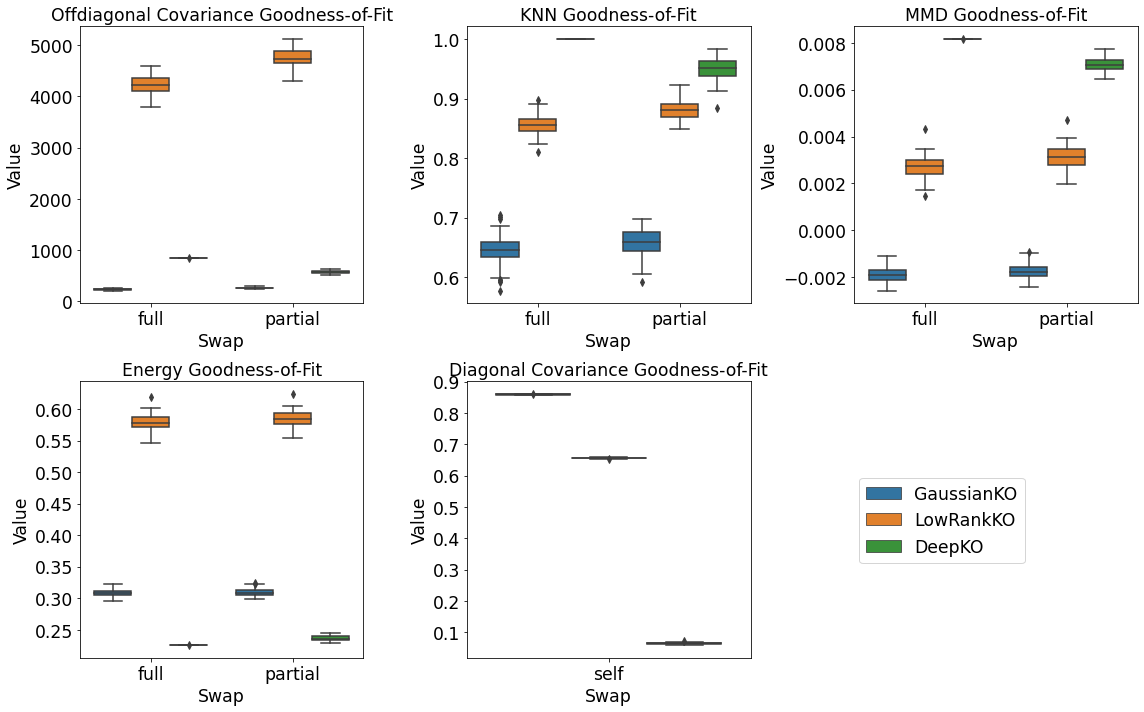

In [18]:
import pandas as pd

res_total = pd.concat([res_gaus, res_lowrank, res_deepko_wm], ignore_index=True, sort=False)

compare_diagnostics(res_total)

## 3. Non-Parametric tests

In [35]:
# Computing the beta values of the knockoffs
gaussian_betas = gaussian.statistic(data_gaussian, save=True)
lowrank_betas = lowrank.statistic(data_lowrank, save=True)
deepko_betas = deepko.statistic(data_deepko, save=True)


Loaded Task Paradigms - Shape: (100, 284)
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 101 subjects and 379 regions...
Done!
Saving file GaussianKO_KObetas_tMOTOR_s1.mat
Loaded Task Paradigms - Shape: (100, 284)
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 101 subjects and 379 regions...
Done!
Saving file LowRankKO_KObetas_tMOTOR_s1.mat
Loaded Task Paradigms - Shape: (100, 284)
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 101 subjects and 379 regions...
Done!
Saving file DeepKO_KObetas_tMOTOR_s1.mat


In [36]:
# Performing corrected and uncorrected Non-Parametric tests to threshold
uncorrected_betas_gaussian, corrected_betas_gaussian = gaussian.threshold(gaussian_betas, save=True)
uncorrected_betas_lowrank, corrected_betas_lowrank = lowrank.threshold(lowrank_betas, save=True)
uncorrected_betas_deepko, corrected_betas_deepko = deepko.threshold(deepko_betas, save=True)

Performing uncorrected non-parametric test...
Performing corrected non-parametric test...
Saving file GaussianKO_uncorrected_betas_tMOTOR_s1.mat
Saving file GaussianKO_corrected_betas_tMOTOR_s1.mat
Performing uncorrected non-parametric test...
Performing corrected non-parametric test...
Saving file LowRankKO_uncorrected_betas_tMOTOR_s1.mat
Saving file LowRankKO_corrected_betas_tMOTOR_s1.mat
Performing uncorrected non-parametric test...
Performing corrected non-parametric test...
Saving file DeepKO_uncorrected_betas_tMOTOR_s1.mat
Saving file DeepKO_corrected_betas_tMOTOR_s1.mat


## 4. Visualizing our results
The results can either be visualized in Matlab using the script our_plots.m, which will show a brain plot with the activation regions; or by a confusion matrix, which gives a comparison on the active regions of the brain for each method compared to the GLM.

In [28]:
TRUE_BETAS = f'./data/output/beta/GLM_betas_{task}.mat' #"true" betas computed with GLM
TRUE_BETAS_CONTROLLED = f'./data/output/beta/GLM_controlled_betas_{task}.mat' #"true" controlled betas computed with GLM
TRUE_BETAS_UNCONTROLLED = f'./data/output/beta/GLM_uncontrolled_betas_{task}.mat' #"true" uncontrolled betas computed with GLM

true_betas = scipy.io.loadmat(TRUE_BETAS)['beta'][subject, :, :]  
true_betas_controlled = scipy.io.loadmat(TRUE_BETAS_CONTROLLED)['beta'][subject, :, :]  
true_betas_uncontrolled = scipy.io.loadmat(TRUE_BETAS_UNCONTROLLED)['beta'][subject, :, :] 



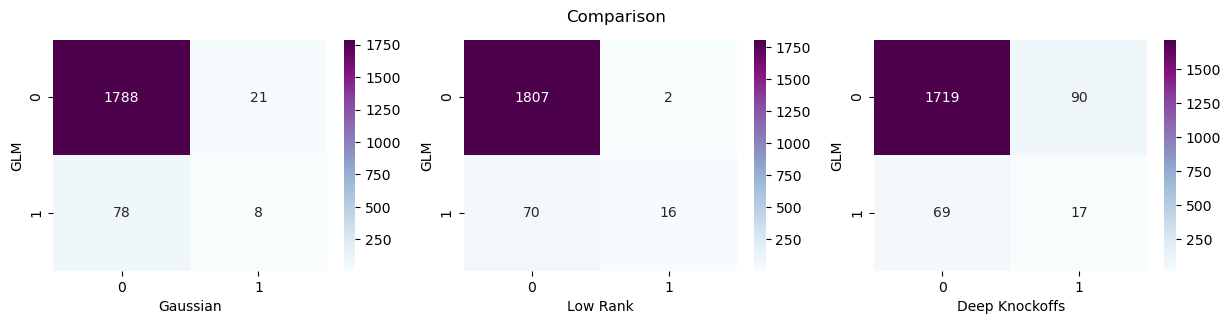

In [37]:
def plot_confusion_matrix(true, methods, true_label, methods_labels):
    true = [0 if x == 0 else 1 for x in true.ravel()]

    fig, axes = plt.subplots(1, len(methods), figsize=(15,3))
    fig.suptitle('Comparison')
    
    for idx, method in enumerate(methods):
        method = [0 if x == 0 else 1 for x in method.ravel()]
        data = {true_label:    true,
        methods_labels[idx]: method
        }

        df = pd.DataFrame(data, columns=[true_label, methods_labels[idx]])

        confusion_matrix = pd.crosstab(df[true_label], df[methods_labels[idx]], rownames=[true_label], 
                                       colnames=[methods_labels[idx]], margins=False)
    
        sns.heatmap(confusion_matrix, ax=axes[idx], annot=True, cmap = 'BuPu',fmt='g')
    
    plt.show()

true = true_betas_controlled
methods = [corrected_betas_gaussian, corrected_betas_lowrank, corrected_betas_deepko]
methods_labels = ['Gaussian', 'Low Rank', 'Deep Knockoffs']
true_label = 'GLM'
plot_confusion_matrix(true, methods, true_label, methods_labels)    

A sample brain plot:
<img src="data/output/img/DeepKO_corrected_betas_tMOTOR_s1_cond2.png">